In [1]:
!pip install gym==0.20.0
!pip install gym_super_mario_bros
!pip install torch-summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.3 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.20.0-py3-none-any.whl size=1650478 sha256=b963c8250c7232e09c5a97ddc5a893c421236de156a8b3347ba1a92edb728e3a
  Stored in directory: /root/.cache/pip/wheels/0d/08/46/9393ca20304119b40cbb5794479b77658b42e3db6d3bdd343e
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 871.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:0000:0100:01
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=495310 sha256=ac47a7b5f5b8158bfeb820e3d4e82b97697ef531e13baa2fa9413

In [2]:
import sys
sys.path.insert(1, '../input/ispratari/src/')

In [3]:
import os
import pathlib

files_to_delete = './*.gif'
files_list = pathlib.Path(os.getcwd()).glob(files_to_delete)
for file_path in files_list:
    os.remove(file_path)

In [4]:
from rl_agents_nes import DuelingAgent
from nes_wrappers import make_nes
from utilities import plot, plot_reward_solo, plot_loss_solo, save_frames_as_gif

In [5]:
import cv2
import copy
import random
import gc
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT
import numpy as np
import torch
import ipywidgets as widgets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm
from collections import deque
from IPython import display
from IPython.display import clear_output
from matplotlib import animation
import base64
from IPython.core.display import display, HTML

cv2.ocl.setUseOpenCL(False)

In [6]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():       
    device =  'cuda'
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device =  'cpu'

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB
Fri Feb 10 08:53:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

Defining the parameters for the training phase

In [7]:
#SET PARAMETERS FOR EXPERIMENT
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 50000

ENVIRONMENT_ID = "SuperMarioBros-1-1-v0"

NUMBER_OF_EPISODES = 7500 #5100
OPTIMIZER = "Adam"
MEMORY_CAPACITY = 30000
BATCH_SIZE = 32
LOSS_FUNC = "Huber"
LEARNING_RATE = 0.00025
REPLAY_INITIAL = 2000
GAMMA      = 0.99

DIR_SAVE_MODEL = None #"../input/smb-weights"

Computing epsilon 

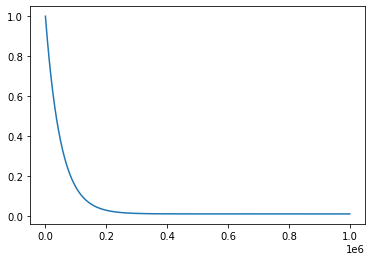

In [8]:
_epsilon = lambda frame: EPSILON_END + (EPSILON_START - EPSILON_END)*np.exp(-frame/EPSILON_DECAY)
plt.plot([_epsilon(frame) for frame in range(1000000)]);

In [9]:
def evaluate(n_ep, a, env, max_frames = 20000, is_creating_gif = False, is_showing = False):      
    step_frames = 0  
    temp_frames = np.zeros((max_frames, 240, 256, 3), dtype=np.uint8)
    
    s = env.reset()
    #s = torch.Tensor([s])
    for step_frames in range(max_frames):
        temp_frames[step_frames] = env.render(mode = 'rgb_array')       
        action = a.act(s, epsilon)
        s, _, d, _ = env.step(action)#s, _, d, _ = env.step(int(action[0]))
        #s = torch.Tensor([s])
        #d = torch.tensor([int(d)]).unsqueeze(0)
        
        if d:
            break
    
    frames = []
    for i in range(step_frames):
        frames.append(temp_frames[i])
        
    if is_creating_gif:
        gif_file = "./smb_" + str(n_ep) + ".gif"
        save_frames_as_gif(frames, filename=gif_file)
        clear_output(wait=True)
    
    if is_showing:
        b64 = base64.b64encode(open(gif_file,'rb').read()).decode('ascii')
        display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

Create the environment and agent

In [10]:
env_id = ENVIRONMENT_ID
env    = gym_super_mario_bros.make(env_id)
env    = make_nes(env, RIGHT_ONLY)

env.seed(seed)

[42]

In [11]:
#agent = DuelingAgent(env.observation_space.shape, env.action_space.n, MEMORY_CAPACITY, 
#                 BATCH_SIZE, GAMMA, LEARNING_RATE, REPLAY_INITIAL, LOSS_FUNC, DIR_SAVE_MODEL)

agent = DuelingAgent(env.observation_space.shape, env.action_space.n, MEMORY_CAPACITY, 
                BATCH_SIZE, GAMMA, LEARNING_RATE, REPLAY_INITIAL, False, LOSS_FUNC, DIR_SAVE_MODEL)


In [12]:
summary(agent.net)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       8,224
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       36,928
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-7                       1,606,144
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       513
├─Sequential: 1-3                        --
|    └─Linear: 2-10                      1,606,144
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      2,565
Total params: 3,293,350
Trainable params: 3,293,350
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       8,224
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       36,928
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-7                       1,606,144
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       513
├─Sequential: 1-3                        --
|    └─Linear: 2-10                      1,606,144
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      2,565
Total params: 3,293,350
Trainable params: 3,293,350
Non-trainable params: 0

## Training
Train the agent and each 2500 episode create a gif to track improvements on agent in  the environment 

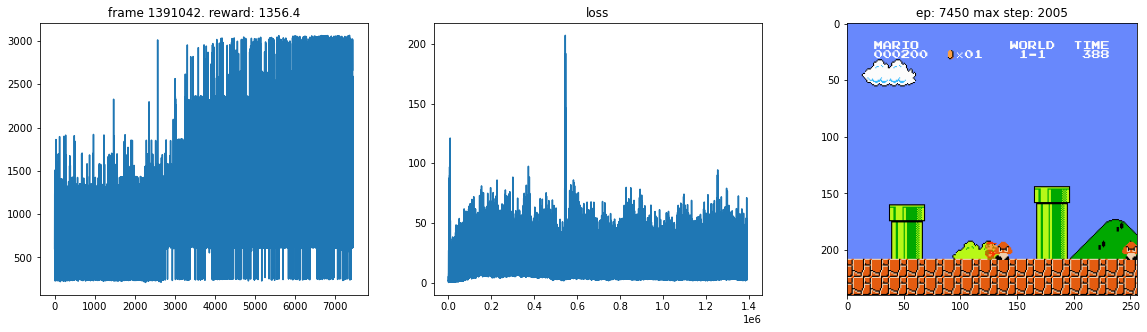

100%|██████████| 7500/7500 [8:28:23<00:00,  4.07s/it]


In [13]:
losses = []
all_rewards = []
flag_got = 0
max_steps = 0
frame_step = 1

env.reset()
        
for ep_idx in tqdm(range(NUMBER_OF_EPISODES)):
    
    state = env.reset()
    #state = torch.Tensor([state])
    episode_reward = 0
    step = 0 
    
    while True:       
        epsilon = _epsilon(frame_step)
        action = agent.act(state, epsilon)
        
        next_state, reward, done, info = env.step(action)#next_state, reward, done, info = env.step(int(action[0]))
        #next_state = torch.Tensor([next_state])
        episode_reward += reward
        #reward = torch.tensor([reward]).unsqueeze(0)
        #action = torch.tensor([action]).unsqueeze(0)
        #done = torch.tensor([int(done)]).unsqueeze(0)
            
        agent.memorize(state, action, reward, next_state, float(done))
        
        step += 1
        frame_step += 1
        
        loss = agent.experience_replay()
        losses.append(loss)
        
        state = next_state
        if done:
            if(info['flag_get']):
                    flag_got+=1
            max_steps = max(step, max_steps)
            gc.collect()
            break

    all_rewards.append(episode_reward)
    
    if ep_idx % 50 == 0:
        rgb_array = env.render(mode='rgb_array');
        plot(frame_step, all_rewards, losses, rgb_array, (step, ep_idx, max_steps))
        
    
    if ep_idx % 1000 == 0:
        evaluate(ep_idx, agent, env, is_creating_gif = True)    

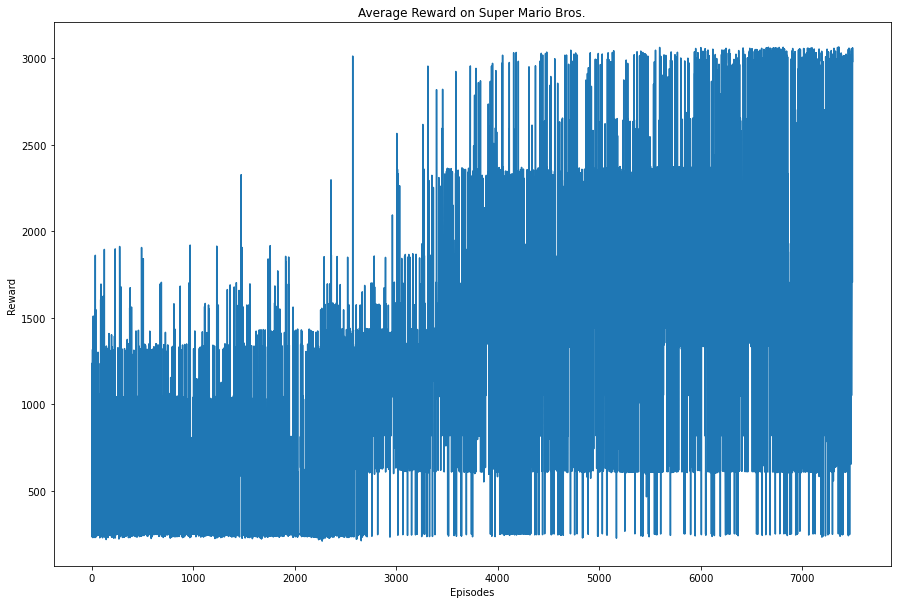

In [14]:
plot_reward_solo(all_rewards, "Super Mario Bros.")

In [15]:
print(np.mean(all_rewards))

1257.4509333333333


The flag is reached x times:

In [16]:
print("In training phase, Mario finihes the level " + str(flag_got) + " times")

In training phase, Mario finihes the level 435 times


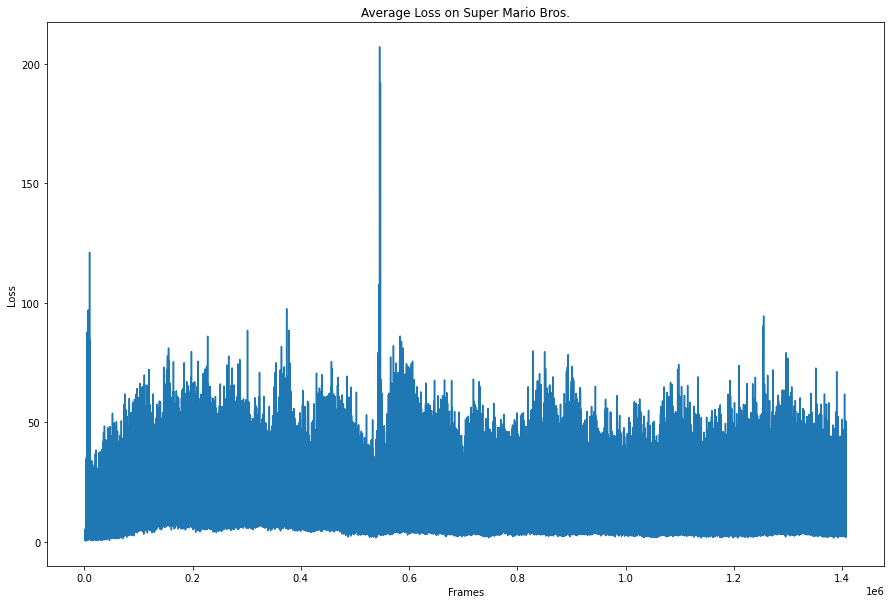

In [17]:
plot_loss_solo(losses, "Super Mario Bros.")

In [18]:
torch.save(agent.net.state_dict(), "DuelingDQN.pt")  

## Testing
Evaluate the model and create a video to visualize the result


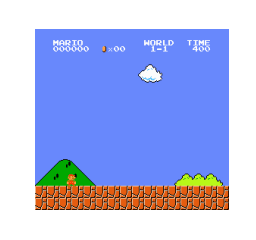

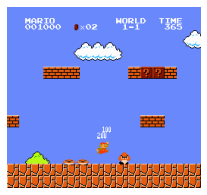

In [19]:
env.reset()

evaluate(ep_idx, agent, env, is_creating_gif = True, is_showing = True)

env.close()